# BRAIN TISSUE SEGMENTATION USING EM ALGORITHM

***Authors:*** Frederik Hartmann and Xavier Beltran
***Date:*** 25-10-2023

EXAMPLE OF OUR DATASET

Reading images...: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


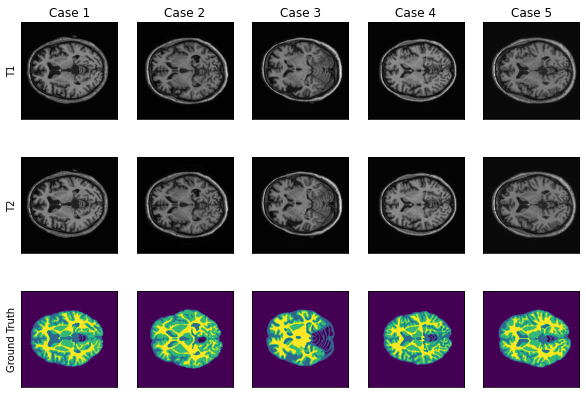

In [20]:
from util import Util
from GMM import GaussianMixtureModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import gc
import seaborn as sns
from sklearn.cluster import KMeans

testFolder = "/home/frederik/Dokumente/Master/Semester_3/misa/gmm/P2_Data/"

util=Util()

GT_vec=[]
T1_vec=[]
T2_vec=[]
fig, axes = plt.subplots(3, 5, figsize=(10, 7))
title=['T1','T2','Ground Truth']
with tqdm(total=5, desc=f'Reading images...') as pbar: 
    for case in range(1,6):
       # Initialize the progress bar
       GT,affine = util.readNiftiImage(testFolder + f"{case}/LabelsForTesting.nii")
       T1,_ = util.readNiftiImage(testFolder + f"{case}/T1.nii")
       T2,_ = util.readNiftiImage(testFolder + f"{case}/T1.nii")
       GT_vec.append(GT)
       T1_vec.append(T1)
       T2_vec.append(T2)
       # Plot the images in the same figure
       util.plot_original_images([T1,T2,GT], case,axes,title, slice=20)
       pbar.update(1)
        
plt.show()

EXECUTION EM ALGORITHM WITH DIFFERENT INITIALIZATION AND WITH T1 AND T1+T2

In [2]:
# Start GMM Algorithm
n_classes = 3
modality_options = ['T1+T2','T1']
CSF_results = []
WM_results = []
GM_results = []
init_types = ['KMeans','Random']
data_frames = []  # Create a list to store DataFrames

for case in range(0,5):
    for modality in modality_options:
        for init_type in init_types:
            print(f"·Segmenting case {case+1} using {init_type} with {modality:<6} as modalities.")
            start_time = time.time()
            if modality=='T1': 
                vec_modalities= T1_vec[case][GT_vec[case] > 0].reshape(-1, 1) 
            else: 
                vec_modalities = np.stack([T1_vec[case][GT_vec[case] > 0].flatten(), T2_vec[case][GT_vec[case] > 0].flatten()], axis=1)

            # Segment Image using EM and GMM
            GMM = GaussianMixtureModel(k=n_classes, data=vec_modalities)
            GMM.initialization(initialization_type=init_type)
            cluster_assignments = GMM.run()
    
            # Re-assign cluster values
            reverted_image_ = util.reconstruct_image(cluster_assignments, GT_vec[case])
            reverted_image = util.fitLabelToGT(reverted_image_.astype(np.uint8), GT_vec[case].astype(np.uint8), n_classes)
    
            # Save Image
            util.save_image(reverted_image,str(case+1),modality,init_type,affine)
    
            # Compute dice
            CSF_results.append(util.dice_coefficient((reverted_image == 1).astype(np.uint8), (GT_vec[case] == 1).astype(np.uint8)))
            WM_results.append(util.dice_coefficient((reverted_image == 2).astype(np.uint8), (GT_vec[case] == 2).astype(np.uint8)))
            GM_results.append(util.dice_coefficient((reverted_image == 3).astype(np.uint8), (GT_vec[case] == 3).astype(np.uint8)))
    
            # Update all parameters of this case before storing in the table
            results = {
                'Case': [case+1],
                'Modalities': [modality],
                'Initialization': [init_type],
                'Time': [time.time() - start_time],
                'Iteration': [GMM.completedIterations],
                'WM': [WM_results[-1]],
                'GM': [GM_results[-1]],
                'CSF': [CSF_results[-1]]
            }
    
            # Store results
            data_frames.append(pd.DataFrame(results))  # Append each DataFrame to the list
            del GMM
            gc.collect()


# Save table
table_results = pd.concat(data_frames, ignore_index=True)  # Concatenate all DataFrames together
table_results.to_csv('results.csv')


·Segmenting case 1 using KMeans with T1+T2  as modalities.
 Iteration 1 of 500
 Iteration 2 of 500
 Iteration 3 of 500
 Iteration 4 of 500
 Iteration 5 of 500
 Iteration 6 of 500
 Iteration 7 of 500
 Iteration 8 of 500
 Iteration 9 of 500
 Iteration 10 of 500
 Iteration 11 of 500
 Iteration 12 of 500
 Iteration 13 of 500
 Iteration 14 of 500
 Iteration 15 of 500
 Iteration 16 of 500
 Iteration 17 of 500
 Iteration 18 of 500
 Iteration 19 of 500
 Iteration 20 of 500
 Iteration 21 of 500
 Iteration 22 of 500
 Iteration 23 of 500
 Iteration 24 of 500
 Iteration 25 of 500
 Iteration 26 of 500
 Iteration 27 of 500
 Iteration 28 of 500
 Iteration 29 of 500
 Iteration 30 of 500
 Iteration 31 of 500
 Iteration 32 of 500
 Iteration 33 of 500
 Iteration 34 of 500
 Iteration 35 of 500
 Iteration 36 of 500
 Iteration 37 of 500
 Iteration 38 of 500
 Iteration 39 of 500
 Iteration 40 of 500
 Iteration 41 of 500
 Iteration 42 of 500
 Iteration 43 of 500
 Iteration 44 of 500
 Iteration 45 of 500
 Iter

VISUAL EXAMPLE OF THE SEGMENTATIONS OBTAINED WITH EM ALGORITHM

Reading images...: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


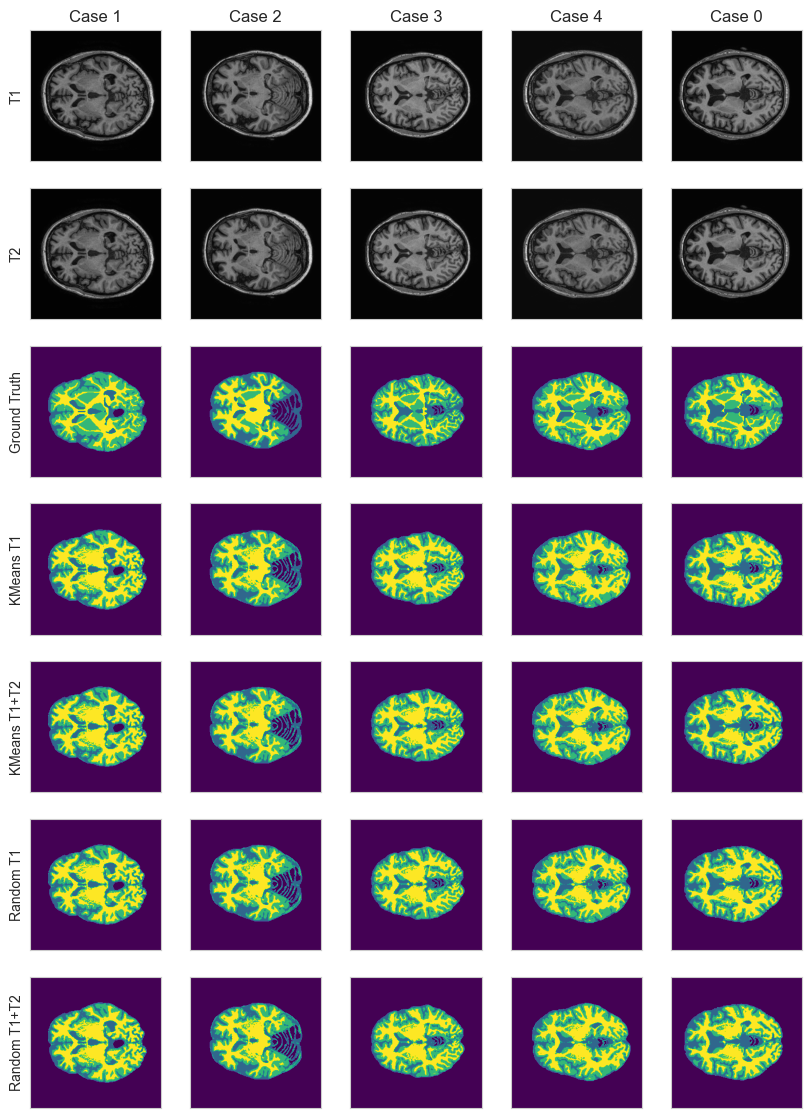

In [4]:
fig, axes = plt.subplots(7,5, figsize=(10, 14))
title=['T1','T2','Ground Truth','KMeans T1','KMeans T1+T2','Random T1','Random T1+T2'] # Different experiments
with tqdm(total=5, desc=f'Reading images...') as pbar: 
    for case in range(0,5):
       # Initialize the progress bar
       KMeans_t1,_ = util.readNiftiImage(f'{case+1}/KMeans_T1.nii')
       KMeans_t1_t2,_ = util.readNiftiImage(f'{case+1}/KMeans_T1+T2.nii')
       Random_t1,affine = util.readNiftiImage(f'{case+1}/Random_T1.nii')
       Random_t1_t2,affine = util.readNiftiImage(f'{case+1}/Random_T1+T2.nii')
       # Plot an example of the segmented images 
       util.plot_original_images([T1_vec[case],T2_vec[case],GT_vec[case],KMeans_t1,KMeans_t1_t2,Random_t1,Random_t1_t2], case,axes,title, slice=20)
       pbar.update(1)
        
plt.show()

### Comparison of Dice

In [3]:
# Define the font size for the plots
fontsize_title = 18
fontsize_labels = 16
fontsize_legend = 14
fontsize_legend_title = 14
fontsize_ticks = 14

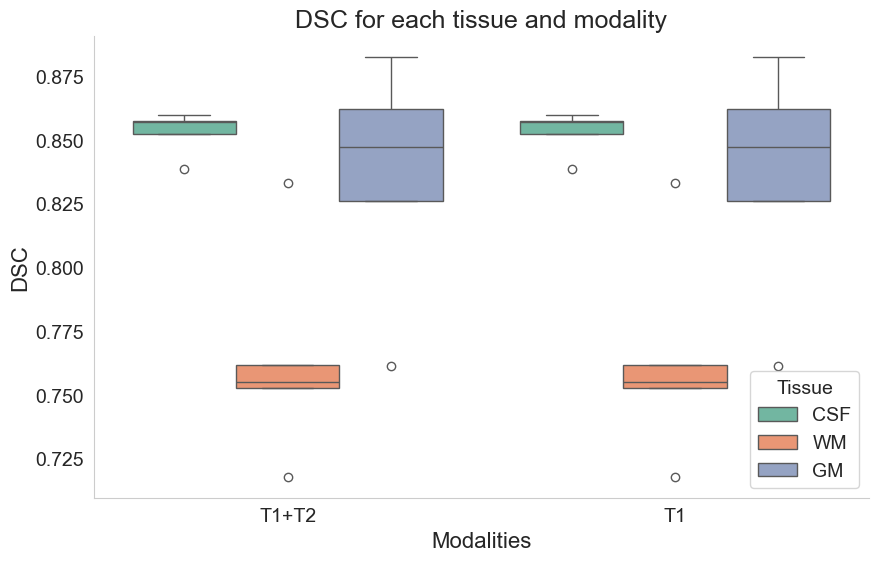

In [6]:
# Read the dataframe
table_results=pd.read_csv('results.csv')

# Start the figure
plt.figure(figsize=(10, 6))
plt.title('DSC for each tissue and modality',fontsize=fontsize_title)
sns.set_style("white")

# Melt the DataFrame to long format for easy plotting
meltedData = table_results.melt(id_vars=['Modalities', 'Initialization'], value_vars=['CSF', 'WM', 'GM'],
                                  var_name='Tissue', value_name='Dice')

filteredData = meltedData[meltedData['Initialization'] == 'KMeans']

# Create the box plot
sns.boxplot(data=filteredData, x='Modalities', y='Dice', hue='Tissue', 
            hue_order=['CSF', 'WM', 'GM'], palette='Set2')

util.Display_Boxplot('Modalities', 'DSC', 'Tissue',path_img="/Users/xavibeltranurbano/PycharmProjects/gmm/src/DSC_per_modalities.png", save_fig=True)


### COMPARISON OF THE COMPUTATIONAL

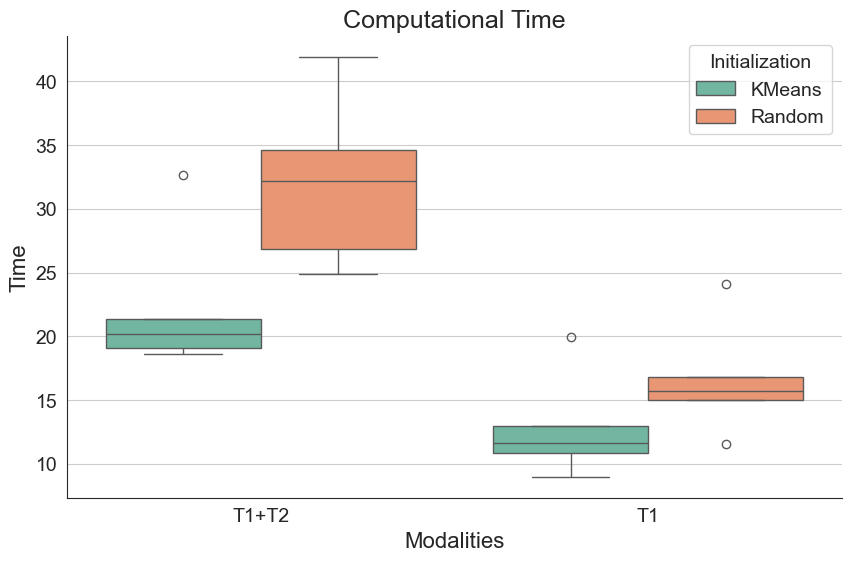

In [7]:
# Start the figure
plt.figure(figsize=(10, 6))
plt.title('Computational Time',fontsize=fontsize_title)

# Create the box plot
sns.boxplot(data=table_results, x='Modalities', y='Time', hue='Initialization', palette='Set2')
util.Display_Boxplot('Modalities', 'Time', 'Initialization',path_img="/Users/xavibeltranurbano/PycharmProjects/gmm/src/Computational_time.png",loc='upper right', save_fig=True)

### COMPARISON WITH SPM

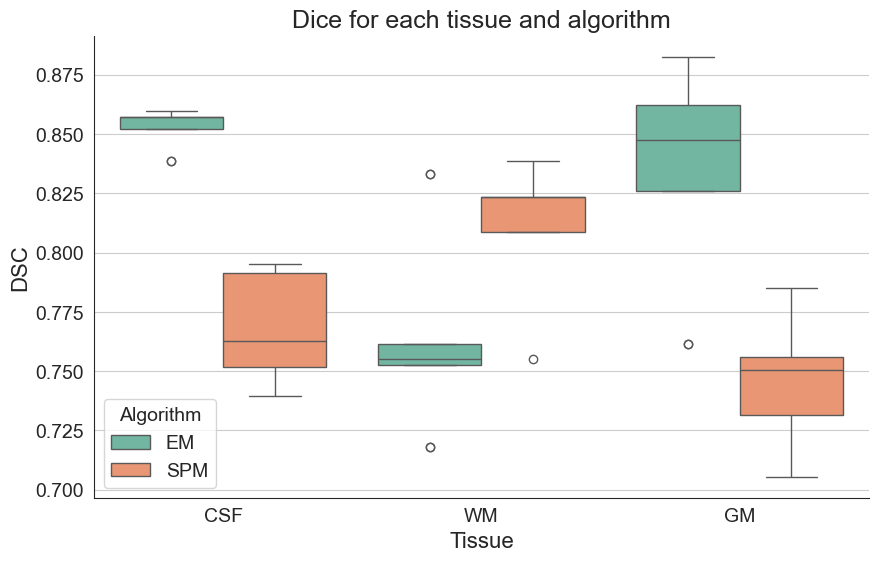

In [9]:
# SPM Data 
WM_spm=[0.8234,0.755,0.8233,0.8087,0.8388]
GM_spm=[0.7505,0.7055,0.7314,0.7561,0.7851]
CSF_spm=[0.7915,0.7517,0.7629,0.7954,0.7394]

# Creating a new DataFrame for 'SPM' modality
data_spm = {
    'Modalities': ['SPM'] * 5,
    'Initialization': ['SPM'] * 5,
    'WM': WM_spm,
    'GM': GM_spm,
    'CSF': CSF_spm
}

df_spm = pd.DataFrame(data_spm)

# Concatenating the new 'SPM' modality DataFrame with the original DataFrame
table_results_ = pd.concat([table_results, df_spm], ignore_index=True)
table_results_['Initialization'] = table_results_['Initialization'].replace('KMeans', 'EM')

# Start the figure
plt.figure(figsize=(10, 6))
plt.title('Dice for each tissue and algorithm', fontsize=fontsize_title)

# Melt the DataFrame to long format for easy plotting
meltedData = table_results_.melt(id_vars=['Modalities', 'Initialization'], 
                                 value_vars=['CSF', 'WM', 'GM'],
                                 var_name='Tissue', value_name='Dice')

filteredData = meltedData[meltedData['Initialization'].isin(['EM', 'SPM'])]
                

# Create the box plot
sns.boxplot(data=filteredData, x='Tissue', y='Dice', hue='Initialization', 
            order=['CSF', 'WM', 'GM'], palette='Set2')

util.Display_Boxplot('Tissue', 'DSC', 'Algorithm',path_img="/Users/xavibeltranurbano/PycharmProjects/gmm/src/DSC_per_algorithm_SPM.png",loc='lower left', save_fig=True)

### KMEANS EXECUTION

In [21]:
# Start KMeans Algorithm
n_classes = 3
modality_options = ['T1+T2','T1']
CSF_results = []
WM_results = []
GM_results = []
data_frames = []  # Create a list to store DataFrames

for case in range(0,5):
    for modality in modality_options:
        print(f"·Segmenting case {case+1} with {modality:<6} as modalities.")
        start_time = time.time()
        if modality=='T1': 
            vec_modalities= T1_vec[case][GT_vec[case] > 0].reshape(-1, 1) 
        else: 
            vec_modalities = np.stack([T1_vec[case][GT_vec[case] > 0].flatten(), T2_vec[case][GT_vec[case] > 0].flatten()], axis=1)

        # Segment Image using EM and GMM
        kmeans = KMeans(n_clusters=n_classes, n_init="auto").fit(vec_modalities)
        cluster_assignments = kmeans.labels_

        # Re-assign cluster values
        reverted_image_ = util.reconstruct_image(cluster_assignments, GT_vec[case])
        reverted_image = util.fitLabelToGT(reverted_image_.astype(np.uint8), GT_vec[case].astype(np.uint8), n_classes)


        # Save Image
        init_type='KMeans'
        util.save_image(reverted_image,str(case+1),modality,init_type,affine)

        # Compute dice
        CSF_results.append(util.dice_coefficient((reverted_image == 1).astype(np.uint8), (GT_vec[case] == 1).astype(np.uint8)))
        WM_results.append(util.dice_coefficient((reverted_image == 2).astype(np.uint8), (GT_vec[case] == 2).astype(np.uint8)))
        GM_results.append(util.dice_coefficient((reverted_image == 3).astype(np.uint8), (GT_vec[case] == 3).astype(np.uint8)))

        # Update all parameters of this case before storing in the table
        results = {
            'Case': [case+1],
            'Modalities': [modality],
            'Initialization': [init_type],
            'Time': [time.time() - start_time],
            'WM': [WM_results[-1]],
            'GM': [GM_results[-1]],
            'CSF': [CSF_results[-1]]
        }

        # Store results
        data_frames.append(pd.DataFrame(results))  # Append each DataFrame to the list


# Save table
table_results_kmean = pd.concat(data_frames, ignore_index=True)  # Concatenate all DataFrames together
table_results_kmean.to_csv('KMEANS.csv')

·Segmenting case 1 with T1+T2  as modalities.
·Segmenting case 1 with T1     as modalities.
·Segmenting case 2 with T1+T2  as modalities.
·Segmenting case 2 with T1     as modalities.
·Segmenting case 3 with T1+T2  as modalities.
·Segmenting case 3 with T1     as modalities.
·Segmenting case 4 with T1+T2  as modalities.
·Segmenting case 4 with T1     as modalities.
·Segmenting case 5 with T1+T2  as modalities.
·Segmenting case 5 with T1     as modalities.


### COMPARISON WITH KMEANS

In [25]:
# Read the dataframe
table_results_kmean=pd.read_csv('KMEANS.csv')

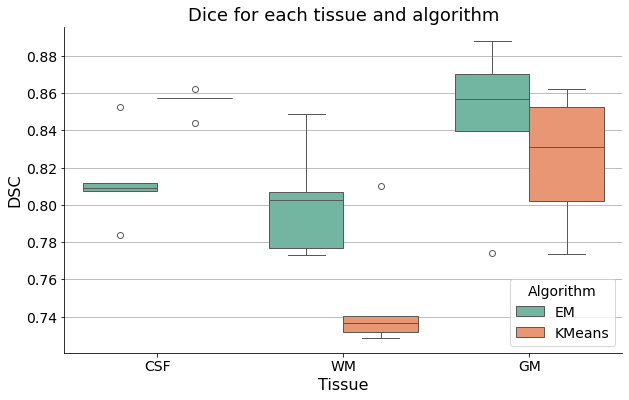

In [29]:
# Concatenating the new KMeans modality DataFrame with the original DataFrame
table_results['Initialization'] = table_results['Initialization'].replace('KMeans', 'EM')
table_results_ = pd.concat([table_results, table_results_kmean], ignore_index=True)

# Start the figure
plt.figure(figsize=(10, 6))
plt.title('Dice for each tissue and algorithm', fontsize=fontsize_title)

# Melt the DataFrame to long format for easy plotting
meltedData = table_results_.melt(id_vars=['Modalities', 'Initialization'], 
                                 value_vars=['CSF', 'WM', 'GM'],
                                 var_name='Tissue', value_name='Dice')

filteredData = meltedData[meltedData['Initialization'].isin(['EM', 'KMeans'])]
filteredData=filteredData[filteredData['Modalities'].isin(['T1+T2'])]

# Create the box plot
sns.boxplot(data=filteredData, x='Tissue', y='Dice', hue='Initialization', 
            order=['CSF', 'WM', 'GM'], palette='Set2')

util.Display_Boxplot('Tissue', 'DSC', 'Algorithm',path_img="DSC_per_algorithm_KM.png", save_fig=True)